# Imports & private packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Private packages via Google Drive

In [ ]:
cd "/content/drive/Othercomputers/PC/Masterarbeit/5 Programmcodes/packages/sgte"

/content/drive/Othercomputers/PC/Masterarbeit/5 Programmcodes/packages/sgte


In [ ]:
!pip install -e .

Obtaining file:///content/drive/Othercomputers/PC/Masterarbeit/5%20Programmcodes/packages/sgte
  Attempting uninstall: sgte
    Found existing installation: SGTE 0.1.0
    Can't uninstall 'SGTE'. No files were found to uninstall.
  Running setup.py develop for sgte


In [ ]:
cd "/content/drive/Othercomputers/PC/Masterarbeit/5 Programmcodes/packages/thermoclassifier"

/content/drive/Othercomputers/PC/Masterarbeit/5 Programmcodes/packages/thermoclassifier


In [ ]:
!pip install -e .

Obtaining file:///content/drive/Othercomputers/PC/Masterarbeit/5%20Programmcodes/packages/thermoclassifier
  Attempting uninstall: thermoclassifier
    Found existing installation: ThermoClassifier 0.1.0
    Can't uninstall 'ThermoClassifier'. No files were found to uninstall.
  Running setup.py develop for thermoclassifier


## Imports

In [ ]:
from thermoclassifier.phases.net import PhaseClassifier
from thermoclassifier.dataset.dataset_creator import *
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# Training routine

In [ ]:
def epoch(net, train_loader, test_loader, loss_func, optimizer, batch_size, seq_len):
    epoch_losses = np.zeros([len(train_loader), ])
    correct = 0
    incorrect = 0
    
    for i, d in enumerate(train_loader):
        # Scale inputs and get predictions
        inp = d[:, :, :-1]
        #inp = d[:, :, [0, 2]]
        inp[:, :, 0] /= 1000
        predictions = net(inp.float()).squeeze()
        
        # Each batch consists of measurement batches, where seq_len measurements are put into one batch. In such a 
        # measurement batch, every measurement has the same label as it needs to be from the same element an phase. 
        # This leads to a target array where the target class is contained for each measurement in the measurement 
        # batch. With this, CrossEntropyLoss would not work as the predictions are made for the whole measurement 
        # batch and CEL therefore expects only on class label per measurement batch. Therefore, only the first 
        # element of the last dimension of d is considered as target (all the entries in the last dimension are the 
        # same anyways so it could be any entry)
        targets = d[:, :, -1][:, 0].long()
                
        correct += (predictions.argmax(dim=-1) == targets).sum().item()
        incorrect += len(targets) - (predictions.argmax(dim=-1) == targets).sum().item()
        
        #print(predictions.argmax(dim=-1), targets)
        
        # Calculate the loss
        loss = loss_func(predictions, targets)
        epoch_losses[i] = loss
        
        # Backward step
        net.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate the network on the test set but DO NOT train on it
    test_loss, test_accuracy = test(net, test_loader, loss_func)

    train_accuracy = correct/(correct + incorrect)
    print('Training accuracy: ', train_accuracy)
    return epoch_losses.mean(), train_accuracy, test_loss, test_accuracy

In [ ]:
# Training and testing routines

def train(net, train_loader, test_loader, batch_size, seq_len):
    # Hyperparameters
    nr_epochs = 250
    lr = 0.001
    
    loss_func = nn.CrossEntropyLoss()
    optimizer = Adam(net.parameters(), lr=lr)
    
    train_losses = np.zeros([nr_epochs, ])
    train_accuracies = np.zeros([nr_epochs, ])
    test_losses = np.zeros([nr_epochs, ])
    test_accuracies = np.zeros([nr_epochs, ])
    
    # Save the net with the lowest training loss as the best net
    best_net = net
    _, _, best_loss, _ = epoch(net, train_loader, test_loader, loss_func, optimizer, batch_size, seq_len)
    
    for i in range(nr_epochs):
        train_losses[i], train_accuracies[i], test_losses[i], test_accuracies[i] = epoch(net, train_loader, test_loader, loss_func, optimizer, batch_size, seq_len)
        
        if test_losses[i] < best_loss:
            best_net = net
        
        if i % 10 == 0:
            print(train_losses[i])
            
    return best_net, train_losses, train_accuracies, test_losses, test_accuracies
        
def test(net, test_loader, loss_func=None): 
    correct = 0
    incorrect = 0

    test_losses = np.zeros([len(test_loader), ])

    for i, d in enumerate(test_loader):
        inp = d[:, :, :-1]
        #inp = d[:, :, [0, 2]]
        inp[:, :, 0] /= 1000
        predictions = net(inp.float())
        targets = d[:, :, -1][:, 0].long()
        
        correct += (predictions.argmax(dim=-1).flatten() == targets).sum().item()
        incorrect += len(targets) - (predictions.argmax(dim=-1).flatten() == targets).sum().item()

        # Get the testing loss
        if loss_func is not None: 
            loss = loss_func(predictions.squeeze(), targets)
            test_losses[i] = loss

    accuracy = correct/(correct + incorrect)
    print('Test accuracy: ', accuracy)
    
    return test_losses.mean(), accuracy

# Network definition

In [ ]:
# Hyperparameters
seq_len = 1
batch_size = 256

# Create the dataset
measurement = 'C'
dc = DatasetCreator(elements=None, splits=(0.8, 0.2), validation=False, seq_len=seq_len, measurement=measurement, user='phase', step=0.5)
train_dataset, test_dataset, val_dataset = dc.get_datasets()

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
if val_dataset:
    val_loader = DataLoader(val_dataset)

Dataset shape:  (205592, 1, 4)


In [ ]:
# Create the network
t = True
net = PhaseClassifier(train=t, measurement=measurement, hidden_layers=2, hidden_size=128)

# Training

In [ ]:
# Train the network
best_net, train_losses, train_accuracies, test_losses, test_accuracies = train(net, train_loader, test_loader, batch_size, seq_len)

# Test the trained network
test(best_net, test_loader)

Test accuracy:  0.49020446241156806
Training accuracy:  0.43663177555546906
Test accuracy:  0.585924745393765
Training accuracy:  0.5348992178683996
1.1902668071326925
Test accuracy:  0.6274780377827879
Training accuracy:  0.6134382660803922
Test accuracy:  0.7015665085905309
Training accuracy:  0.6678372699326822
Test accuracy:  0.6718106196066237
Training accuracy:  0.7092980271605899
Test accuracy:  0.7432947212936329
Training accuracy:  0.7388517062920736
Test accuracy:  0.7637020912695328
Training accuracy:  0.7681670493015292
Test accuracy:  0.7949545207183394
Training accuracy:  0.7911543250710145
Test accuracy:  0.7743916660188137
Training accuracy:  0.8147836491692284
Test accuracy:  0.8430576070901034
Training accuracy:  0.8288308883614148
Test accuracy:  0.833300940682578
Training accuracy:  0.8425084633643333
Test accuracy:  0.8766617429837519
Training accuracy:  0.8557725981555703
0.36994807092259774
Test accuracy:  0.8487911062738086
Training accuracy:  0.8665755476866804

(0.0, 0.9562893570706678)

In [ ]:
torch.save(best_net, 'PhaseClassifier_9563.pth')

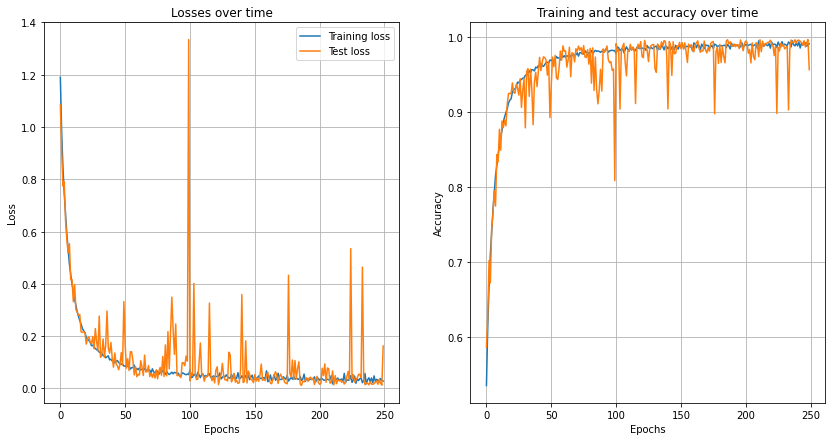

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
ax[0].plot(train_losses, label='Training loss')
ax[0].plot(test_losses, label='Test loss')
ax[0].set_xlabel('Epochs'), ax[0].set_ylabel('Loss')
ax[0].set_title('Losses over time')
ax[0].grid()
ax[0].legend()
ax[1].plot(train_accuracies, label='Training accuracy')
ax[1].plot(test_accuracies, label='Test accuracy')
ax[1].set_xlabel('Epochs'), ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test accuracy over time')
ax[1].grid()
ax[0].legend()
plt.show()

In [ ]:
#net = torch.load(r"C:\Users\danie\Documents\Montanuni\Masterarbeit\5 Programmcodes\packages\ThermoClassifier\ThermoClassifier\phases\models\new\PhaseClassifier.pth")
test(best_net, test_loader)

torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size([256, 1, 34]) torch.Size([256])
torch.Size(

(0.0, 0.9785042369587188)